# Federated Learning for Sequential (Text) data
This notebook contains all the necessary code to perform the experiments for this exercise! Start by reading the `ReadMe.md` to have an setup ready. Afterward, you can start with this notebook! 

In [37]:
import os
import torch
import nltk
import torch
import flwr as fl
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch import nn
from torch import optim
from nltk.lm import Vocabulary
from nltk.corpus import reuters
from typing import Dict
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder
from flwr.common import NDArrays, Scalar
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE} using PyTorch {torch.__version__}")

Training on cpu using PyTorch 2.4.0


## Parameters

This section defines all the possible hyperparameters that can be used to configure the model. Just update the values to your desired configuration.

In [32]:
# Dataset hyperparameters
MAX_LEN = 60

# Model hyperparameters
EMBED_SIZE = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 2
DROPOUT = 0.5

# Training hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.01
NUM_EPOCHS = 100
NUM_CLIENTS = 15

# General hyperparameters
RANDOM_STATE = 42
VERBOSE = True
np.random.seed(RANDOM_STATE)

## Load data
Next, we define the datastructure, load the dataset and perform the necessary pre-processing. We begin by defining the dataset.

In [38]:
class ReutersDataset(Dataset):
    def __init__(self, texts, labels, maxlen):
        self.texts = [text[:maxlen] for text in texts]
        self.labels = labels
        self.maxlen = maxlen

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = torch.tensor(self.texts[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return text, label

Afterward, we define all the necessary methods to load and pre-process the data. Therefore, we performed tokenization, stopword removal, building up a vocabulary, and encoded the tokens into a numerical representation on our own. For this we used NLTK and scikit-learn respectively. Furthermore, we incorporated a max length into our feature to reduce further computational resources. Additionally, we added padding to the text-feature to unify it, as the input for the model. For this, we used pytorch. Lastly, we label encode the target feature with scikit-learn.

In [39]:
def _collate_fn(batch, vocab):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    labels = torch.tensor(labels, dtype=torch.long)
    return texts_padded, labels


def _remove_stopwords(text):
    stop = set(nltk.corpus.stopwords.words("english"))
    return (
        pd.Series(text)
        .str.lower()
        .replace(r"[^\w\s]", "", regex=True)
        .apply(nltk.word_tokenize)
        .apply(
            lambda sentence: " ".join([word for word in sentence if word not in stop])
        )
    )


def _process_labels(labels):
    return pd.Series(labels).apply(lambda x: x[0] if x else "unknown")


def load_dataset(maxlen):
    nltk.download("reuters")
    nltk.download("stopwords")
    nltk.download("punkt")

    # Load documents and their categories
    documents = reuters.fileids()
    categories = [reuters.categories(fileid) for fileid in documents]

    # Load document content
    data = [reuters.raw(fileid) for fileid in documents]

    text = _remove_stopwords(data)
    tokens = [nltk.word_tokenize(sentence) for sentence in text]

    # Flatten the list of tokens for vocabulary creation
    flat_tokens = [token for sentence in tokens for token in sentence]
    vocab = Vocabulary(flat_tokens)

    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(_process_labels(categories))

    # Add a padding token to the vocabulary
    vocab.update(["<pad>"])
    encoded_texts = [[vocab[token] for token in sentence] for sentence in tokens]

    # Apply maxlen to encoded texts
    encoded_texts = [text[:maxlen] for text in encoded_texts]

    encoded_df = pd.DataFrame(
        {
            "text": encoded_texts,
            "category": labels,
        }
    )

    return encoded_df, vocab, label_encoder


def create_dataloader(text, labels, vocab, maxlen, shuffle = True):
    dataset = ReutersDataset(text.tolist(), labels.tolist(), maxlen)
    return DataLoader(
        dataset,
        batch_size=32,
        shuffle=shuffle,
        collate_fn=lambda x: _collate_fn(x, vocab),
    )


Next, we need to call the `load_dataset` method with the desired max length.

In [40]:
df, vocab, label_encoder = load_dataset(MAX_LEN)

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/maxkleinegger/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxkleinegger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maxkleinegger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Lastly, we split the dataset into training and testing sets, based on a 80:20 ratio and transform them into PyTorch DataLoader objects.

In [41]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["category"], test_size=0.2, random_state=RANDOM_STATE
)

In [42]:
train_loader = create_dataloader(train_texts, train_labels, vocab, MAX_LEN)
test_loader = create_dataloader(test_texts, test_labels, vocab, MAX_LEN, shuffle=False)

## State-of-the-art baseline
This section implements and evaluates a state-of-the-art bidirectional LSTM model for text classification.

### Implementation
First, we define the model itself with its necessary parameters. Afterward, we implement a method 
- to train the model based on provided dataset.
- evaluate the model based on a provided dataset by computing the utility metrics accuracy, precision, recall and f1.

In [43]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, padding_idx, embed_size=128, hidden_size=256, num_layers=2, dropout=0.5):
        super(BidirectionalLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.rnn = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.rnn(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        out = self.dropout(hidden)
        out = self.fc(out)
        return out


In [44]:
def train_model(model, train_loader, num_epochs, optimizer, device=DEVICE, verbose=False):
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0
        correct = 0
        total = 0

        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

In [45]:
def evaluate_model(model, test_loader, device=DEVICE, verbose=False):
    criterion = nn.CrossEntropyLoss()
    model.eval()

    total, correct = 0, 0
    total_loss = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    total_loss /= len(test_loader)
    accuracy = correct / total

    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    if verbose:
        print(f"Test Loss: {total_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    return total_loss, accuracy, precision, recall, f1

### Training
In this section, we train the model, based on `NUM_EPOCHS` specified. We however, evaluate the model after each epoch and save the results to a prior specified file.

In [46]:
def run_centralised(model, train_loader, test_loader, epochs, lr, momentum=0.9, device=DEVICE, verbose=False):
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    train_model(model, train_loader, epochs, optim, device)
    loss, accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)

    if verbose:
        print(f"Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    return accuracy, loss, precision, recall, f1


Defining the file to save the results to:

In [47]:
file_path = "results/results_baseline.csv"
os.makedirs("results", exist_ok=True)

Initializing the bidirectional LSTM, based on the provided hyperparameters:

In [48]:
model = BidirectionalLSTM(
    vocab_size=len(vocab),
    output_size= len(label_encoder.classes_),
    padding_idx=vocab["<pad>"],
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

Lastly, we need to start the training:

In [ ]:
%%time
epochs_count = 0
for epochs in range(1):
    epochs_count += 1
    acc, loss, precision, recall, f1 = run_centralised(model, train_loader, test_loader, epochs=1, lr=LEARNING_RATE, verbose=False)
    with open(file_path, "a") as file:
        file.write(f"{epochs_count},{acc},{loss},{precision},{recall},{f1}\n")

## LSTM to be federated
This section implements and evaluates the model we want to federate. Futher we implement the server and client for the federation process and start a simulation to evaluate its performance.

### Implementation
First, we define the model itself with its necessary parameters.

In [51]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        output_size,
        padding_idx,
        embed_size=128,
        hidden_size=256,
        num_layers=2,
        dropout=0.5,
    ):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.rnn = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=dropout,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.rnn(embedded)
        hidden = hidden[-1]
        out = self.dropout(hidden)
        out = self.fc(out)
        return out

### Training
To have a value to compare to, we train and evaluate the model based on `NUM_EPOCHS` specified. The reason for this is to see how well the model overall performs and furthermore have a upper bound for our federated model performance.

First, define the file to save the results to:

In [52]:
file_path = "results/results_no_fed.csv"
os.makedirs("results", exist_ok=True)

Initializing the uni-directional LSTM, based on the provided hyperparameters:

In [53]:
model = LSTM(
    vocab_size=len(vocab),
    output_size= len(label_encoder.classes_),
    padding_idx=vocab["<pad>"],
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

Initializing the bidirectional LSTM, based on the provided hyperparameters:

In [ ]:
%%time
epochs_count = 0
for epochs in range(1):
    epochs_count += epochs
    acc, loss, precision, recall, f1 = run_centralised(model, train_loader, test_loader, epochs=1, lr=LEARNING_RATE, verbose=False)
    with open(file_path, "a") as file:
       file.write(f"{epochs_count},{acc},{loss},{precision},{recall},{f1}\n")


### Federated LSTM
Now we deal with federating the model and data.

#### Partition data
We start by partitioning the data into `num_partitions`. This is crucial for further work.

In [57]:
def partition_dataset(train_loader, test_loader, vocab, num_partitions, batch_size, val_ratio=0.1):
    # Extract dataset from DataLoader
    train_dataset = train_loader.dataset
    test_dataset = test_loader.dataset

    # Calculate partition lengths
    num_images = len(train_dataset)
    partition_len = [num_images // num_partitions] * num_partitions
    partition_len[-1] += (
        num_images % num_partitions
    )  # Add remainder to the last partition

    trainsets = random_split(
        train_dataset, partition_len, torch.Generator().manual_seed(2023)
    )

    # Create DataLoaders with train+val support
    trainloaders = []
    valloaders = []
    for trainset in trainsets:
        num_total = len(trainset)
        num_val = int(val_ratio * num_total)
        num_train = num_total - num_val

        train_subset, val_subset = random_split(trainset, [num_train, num_val], torch.Generator().manual_seed(2023))

        trainloaders.append(DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=lambda x: _collate_fn(x, vocab)))
        valloaders.append(DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=lambda x: _collate_fn(x, vocab)))

    # Create DataLoader for the test set
    testloader = DataLoader(test_dataset, batch_size=128, collate_fn=lambda x: _collate_fn(x, vocab))

    return trainloaders, valloaders, testloader

In [58]:
trainloaders, valloaders, testloader = partition_dataset(train_loader, test_loader, vocab, NUM_CLIENTS, BATCH_SIZE)

##### Visualization
We also added a small visualization of the distribution of classes within on partition.

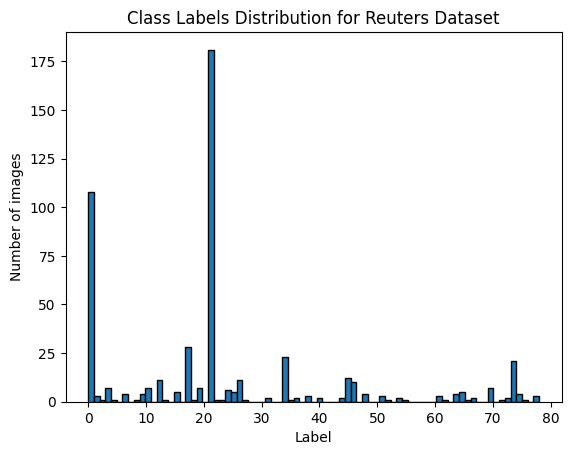

In [80]:
train_dataset = train_loader.dataset
partition_indices = train_partition.indices
labels = [train_dataset[i][1].item() for i in partition_indices]

# Visualize histogram
plt.hist(labels, bins=len(label_encoder.classes_), edgecolor='black')
plt.xlabel("Label")
plt.ylabel("Number of images")
plt.title("Class Labels Distribution for Reuters Dataset")
plt.show()


#### Client
Next, we implement the client based on the Flower library

In [60]:
class ReutersClient(fl.client.NumPyClient):
    def __init__(self, vocab_size, output_size, padding_idx, embed_size, hidden_size, num_layers, dropout, device, learning_rate, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.device = device
        self.learning_rate = learning_rate
        self.model = LSTM(
            vocab_size=vocab_size,
            output_size= output_size,
            padding_idx=padding_idx,
            embed_size=embed_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout
        ).to(device)


    def set_parameters(self, parameters):
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        optim = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9)
        train_model(model=self.model, train_loader=self.trainloader, num_epochs=1, optimizer=optim, device=self.device, verbose=False,)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy, precision, recall, f1 = evaluate_model(self.model, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

And add some additional function to create and evaluate the client.

In [61]:
def get_evaluate_fn(vocab_size, output_size, padding_idx, embed_size, hidden_size, num_layers, dropout, device, testloader):
    def evaluate_fn(server_round, parameters, config):
        model = LSTM(
            vocab_size=vocab_size,
            output_size= output_size,
            padding_idx=padding_idx,
            embed_size=embed_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout
        ).to(device)

        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        loss, accuracy, precision, recall, f1 = evaluate_model(
            model, testloader
        )
        return loss, {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

    return evaluate_fn

In [62]:
def generate_client_fn(vocab_size, output_size, padding_idx, embed_size, hidden_size, num_layers, dropout, device, learning_rate, trainloaders, valloaders):
    def client_fn(cid: str):
        return ReutersClient(vocab_size, output_size, padding_idx, embed_size, hidden_size, num_layers, dropout, device, learning_rate, trainloader=trainloaders[int(cid)], valloader=valloaders[int(cid)]).to_client()

    return client_fn

#### Server
Lastly, we configure the aggregating strategy for the server and define the number of clients via the `NUM_CLIENTS` parameter. We further use all models to train and evaluate on all models available.

In [63]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1, 
    fraction_evaluate=1,  
    min_available_clients=NUM_CLIENTS, 
    evaluate_fn=get_evaluate_fn(len(vocab), len(label_encoder.classes_), vocab["<pad>"], EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT, DEVICE, testloader)
)

In [64]:
client_fn_callback = generate_client_fn(len(vocab), len(label_encoder.classes_), vocab["<pad>"], EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT, DEVICE, LEARNING_RATE, trainloaders, valloaders)

#### Training
Next, we start the simulation of our federated ml model 

In [ ]:
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=1),
    strategy=strategy,
)

##### Results
Lastly, we save the results to a csv file

In [106]:
rows = []
for i in range(len(history.metrics_centralized['accuracy'])):
    loss = history.losses_centralized[i][1]
    epoch = history.metrics_centralized['accuracy'][i][0]
    accuracy = history.metrics_centralized['accuracy'][i][1]
    precision = history.metrics_centralized['precision'][i][1]
    recall = history.metrics_centralized['recall'][i][1]
    f1 = history.metrics_centralized['f1'][i][1]
    
    rows.append({
        'epoch_nr': epoch,
        'accuracy': accuracy,
        "loss": loss,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

df_metrics = pd.DataFrame(rows)
df_metrics.to_csv(f"results/results_federated_{NUM_CLIENTS}_clients.csv", index=False)